In [1]:
from argparse import Namespace
import os
import sys
sys.path.insert(0,'..')

from joblib import delayed, Parallel
from tqdm.notebook import tqdm
from datetime import datetime
import h5py

import torch
from torchmetrics import MeanSquaredError
import pandas as pd
import numpy as np

In [2]:
from hpl.scripts.test_data_assimilation_encoder import mesh_test_single_model
from hpl.utils.postprocessing import (
    load_test_simulations,
    load_hydra_config,
)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from cycler import cycler

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)
plt.rc('image', cmap='gray')
plt.rcParams['axes.prop_cycle'] = cycler(color=hereon_color_array)

In [4]:
device = torch.device("cuda")

test_data_dir = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/testing/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
experiment_dir = "/gpfs/work/zinchenk/hpl_logs/data_assimilation/multirun/2023-08-16/17-34-47/11"
n_simulations = 25
noise_std_min = 0.1
noise_std_max = 3.0
mask_fraction_min = 0.1
mask_fraction_max = 0.9
mesh_steps = 15
ignore_edges = True
output_directory = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/"
n_jobs = 10
seed = 101

# run data assimilation mesh test

In [5]:
timestamp = datetime.now().strftime("%Y-%d-%m-%H-%M")
output_directory = os.path.join(output_directory, timestamp)
os.makedirs(output_directory)

In [6]:
args = Namespace(
    data_path=test_data_dir,
    experiment_dir=experiment_dir,
    output_dir=output_directory,
    noise_std_min=noise_std_min,
    noise_std_max=noise_std_max,
    mask_fraction_min=mask_fraction_min,
    mask_fraction_max=mask_fraction_max,
    mesh_steps=mesh_steps,
    seed=seed,
    n_simulations=n_simulations,
    device=str(device),
    ignore_edges=ignore_edges,
    n_jobs=n_jobs,
)

In [143]:
mesh_test_single_model(args, experiment_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [04:24<00:00,  1.17s/it]


# plotting

In [144]:
simulations = load_test_simulations(test_data_dir, n_simulations)
rmse_func = MeanSquaredError(squared=False)
config = load_hydra_config(experiment_dir)

In [145]:
rmse_dict = dict(
    noise_std=[],
    mask_fraction=[],
    rmse=[],
)

output_files = os.listdir(output_directory)
for output in tqdm(output_files):
    path_to_file = os.path.join(output_directory, output)
    ground_truth = simulations
    with h5py.File(path_to_file, "r") as file:
        ignore_edges = file.attrs["ignore_edges"]
        experiment_dir = file.attrs["experiment_dir"]
        rmse_dict["noise_std"].append(file.attrs["noise_std"])
        rmse_dict["mask_fraction"].append(file.attrs["mask_fraction"])
        reconstruction = torch.from_numpy(file["reconstruction"][:])
        if ignore_edges:
            config = load_hydra_config(experiment_dir)
            input_window_extend = config.datamodule.dataset.input_window_extend
            ground_truth = simulations[:, input_window_extend:-input_window_extend+1]
        avg_rmse = [rmse_func(reconstruction[i], ground_truth[i]) for i in range(reconstruction.size(0))]
        avg_rmse = torch.tensor(avg_rmse).mean().item()
        rmse_dict["rmse"].append(avg_rmse)
        
rmse_frame = pd.DataFrame(rmse_dict)

  0%|          | 0/225 [00:00<?, ?it/s]

In [146]:
rmse_frame.sort_values(["noise_std", 'mask_fraction'], inplace=True)

In [147]:
rmse_frame

,noise_std,mask_fraction,rmse
148,0.1,0.100000,0.108536
220,0.1,0.157143,0.109895
179,0.1,0.214286,0.111676
211,0.1,0.271429,0.114225
16,0.1,0.328571,0.117825
...,...,...,...
55,3.0,0.671429,1.646062
130,3.0,0.728571,1.725175
105,3.0,0.785714,1.795601
102,3.0,0.842857,1.900199


In [148]:
noise_std_flatten = rmse_frame.noise_std.values
mask_fraction_flatten = rmse_frame.mask_fraction.values
rmse_flatten = rmse_frame.rmse.values

In [149]:
noise_mesh = noise_std_flatten.reshape(mesh_steps, mesh_steps)
mask_fracton_mesh = mask_fraction_flatten.reshape(mesh_steps, mesh_steps)
rmse_mesh = rmse_flatten.reshape(mesh_steps, mesh_steps)

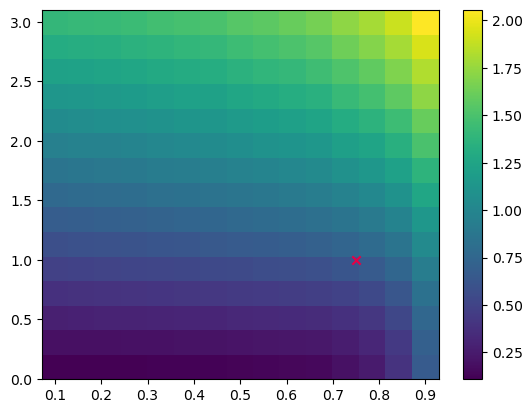

In [150]:
plt.pcolor(mask_fracton_mesh[0, :], noise_mesh[:, 0], rmse_mesh, cmap="viridis")
plt.colorbar()
plt.scatter(config.datamodule.dataset.mask_fraction, config.datamodule.dataset.additional_noise_std, marker='x')